## Libraries

In [1]:
# %load_ext autoreload
# %autoreload 2

import sys
sys.path.append('..')
from src.grass_functions import*
from src.data.process_inputs import*


# Parameters

In [10]:
#set project variables
Project_Area = 'miami_walton'
GRASS_GIS_Projection = projection = '26918' #set to None if you want to use the DEM's original projection

## Set variables analysis
data_scale = 'HUC12' #other options HUC12, HUC10, HUC8 OR the field name of the source data to be split <-- case sensitive
select_data = '030902061500' #     # Value within the filter_field used for data selection
to_headwaters = False #False if only interested in local huc area
input_shp_name = 'None' #None or must be populated populated with a shapefile polygons if data_scale != HUCXX

In [11]:
## Set basin scale for watershed analysis
watershed_scale = 'HUC12' #other options HUC12, HUC10, HUC8 OR GRASS DEFINED <-- case sensitive

In [12]:
## Paths:
parent_dir = pl.Path('/home/jovyan/app/data')
current_dir = pl.Path(os.getcwd())
outputs_dir =parent_dir/'Rasters'/Project_Area/'Outputs'
vector_dir = parent_dir/'Vectors'/Project_Area
raster_dir = parent_dir/'Rasters'/Project_Area
git_data_repo = current_dir/'data_repository'
directory = outputs_dir

#set projection if none exists
if not GRASS_GIS_Projection:
    dem_vrt = raster_dir/'dem'/'dem_{}.vrt'.format(select_data)
    GRASS_GIS_Projection = projection = get_raster_epsg(dem_vrt)
    
    
## GRASSGIS Location and Mapsets
Location = Project_Area+'_'+GRASS_GIS_Projection
Mapset = 'PERMANENT'
jobs =['Local','NonLocal']#

### Start new grass session

In [13]:
initialize_grass_db(Location, Mapset, GRASS_GIS_Projection)

Database Location Exists
Database Mapset Exists


#### Review existing files

In [14]:
#list all grass files
grass_maps = list_existing_grass()

Available vector maps:
HUC120309@PERMANENT
basins@PERMANENT
tmp_bsn@PERMANENT
tmp_bsn_buffer@PERMANENT

Available raster maps:
USGS_13_n26w081_20221103@PERMANENT
dem_030902061500@PERMANENT


In [15]:
#remove old files if needed
remove_grass_data(grass_maps,'None','raster') #all as 

In [16]:
#Define file Names
huc12s = 'v_HUC12_Boundaries'
upstream_huc12s = 'v_'+select_data+'upstream_HUC_Boundaries'
selected_huc12 = 'v_'+select_data+'_HUC_Boundary'
nhd = 'v_nhd'
upstream_nhd = 'v_'+select_data+'upstream_nhd'
pour_points = 'v_HUC_12_pour_points'
pour_points_upstream = 'v_HUC_12_pour_points_upstream'
selected_pour_points = 'v_'+select_data+'_HUC_12_pour_points'

### Get NHD data

In [17]:
#download NHD geodatabase if not already saved
wbd = nhd_download(select_data,vector_dir)

gdb is already downloaded


In [18]:
#read in HUC12s vector file from NHD
local_huc4 = gpd.read_file(vector_dir/wbd, layer='WBDHU12')

In [19]:
#reformat fields to handle disparate USGS data formats
local_huc4 = lower_pd_cols(local_huc4)

In [20]:
## function to get most downstream HUC12 if HUC10 or HUC8 is entered
select_data = get_downstream_huc12(select_data,local_huc4)

In [21]:
#get upstream HUC12 watersheds
if to_headwaters:
    upstream_list = get_upstream_extent_usgs(select_data) #selected huc12
else:
    #upstream_list = get_just_upstream_basins_usgs(select_data)
    upstream_list = [select_data]

In [22]:
#import relevant NHD files for analysis
nhd_to_grass(git_data_repo,vector_dir,select_data,upstream_list,huc12s,selected_huc12,upstream_huc12s,pour_points,pour_points_upstream,nhd,upstream_nhd,force='No') # add 'Yes' optional parameter if you want to force recreate


         Location PROJ_INFO is:
         name: NAD83 / UTM zone 18N
         datum: nad83
         ellps: grs80
         proj: utm
         zone: 18
         no_defs: defined
         init: EPSG:26918

         Dataset PROJ_INFO is:
         name: NAD83
         datum: nad83
         ellps: grs80
         proj: ll
         no_defs: defined

         ERROR: proj
Importing
</home/jovyan/app/data/Vectors/miami_walton/NHDPLUS_H_0309_HU4_GDB.gdb> ...
Check if OGR layer <WBDHU12> contains polygons...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
Creating attribute table for layer <WBDHU12>...
Default driver / database set to:
driver: sqlite
database: $GISDBASE/$LOCATION_NAME/$MAPSET/sqlite/sqlite.db
Importing 238 features (OGR layer <WBDHU12>)...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42 

d.vect complete.
d.vect complete.
d.vect complete.


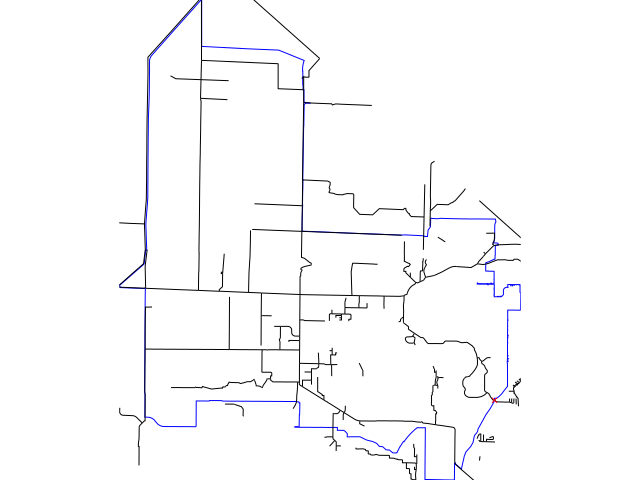

In [23]:
##print watershed flowlines @ Regional scale to confirm data and extent
gs.parse_command('g.region',vector = upstream_huc12s)
gs.run_command('d.erase')
gs.run_command('d.vect', map= upstream_huc12s,color='blue',fill_color='none')
gs.run_command('d.vect', map= upstream_nhd,color='black',fill_color='none')
gs.run_command('d.vect', map= pour_points_upstream,color='red',fill_color='none')
Image(filename="map.png")

### Get Raster data

#### Must first run DEM Download Notebook at
[DEM Download](DEM_download.ipynb#section_id1)
<a id='section_id1'></a>

#### Must first run RAS_DEM_Prep Download Notebook at
[RAS_DEM Prep](RAS_DEM_Prep.ipynb#section_id1)
<a id='section_id1'></a>

## Calculate Watershed Attributes and Stream Network

In [24]:
# processing for each HUC-12 individually
huc_key = grass_watershed_processing(data_scale,upstream_list,upstream_huc12s,upstream_nhd,vector_dir,raster_dir,filter_size = 15, carve = True, force=False) #last 3 are optional parameters. filter size in meters

         exists and will be overwritten
Buffering areas...
 100
Cleaning buffers...
Building parts of topology...
Building topology for vector map
<v_030902061500upstream_HUC_Boundaries_buffer@PERMANENT>...
Registering primitives...
Snapping boundaries...
Reading features...
Snap vertices Pass 1: select points
   0 100
Snap vertices Pass 2: assign anchor vertices
   4   9  14  19  24  29  34  39  44  49  54  59  64  69  74  79  84  89  94  99 100
Snap vertices Pass 3: snap to assigned points
   0 100
Breaking polygons...
Breaking polygons (pass 1: select break points)...
 100
Breaking polygons (pass 2: break at selected points)...
 100
Removing duplicates...
 100
Breaking boundaries...
   0 100
Removing duplicates...
 100
Cleaning boundaries at nodes
 100
Building topology for vector map
<v_030902061500upstream_HUC_Boundaries_buffer@PERMANENT>...
Building areas...
   0 100
Removing dangles...
 100
Removing bridges...
 100
Attaching islands...
Building topology for vector map
<v_0309020

Median filtering of mesh for 030902061500


   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


Processing stream lines for 030902061500


Copying vector features from <v_030902061500upstream_nhd@PERMANENT>...
   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71  73  75  77  79  81  83  85  87  89  91  93  95  97  99 100
Copying vector features from <tmp_huc_buffer_nhd@PERMANENT>...
  50 100
Breaking lines...
   0  12  20  25  33  35  42  50  55  59  61  65  69  72  75  79  82  86  89  93  96 100
Selecting lines...
   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71  73  75  77  79  81  83  85  87  89  91  93  95  97  99 100
Building topology for vector map <v_stream_030902061500@PERMANENT>...
Registering primitives...
v.overlay complete.
         attributes
Exporting 311 features...
   5  11  17  23  29  35  41  47  53  59  65  71  77  83  89  95 100
v.out.ogr complete. 311 features (Line String type) written to
<v_stream_030902061500> (ES

Carving DEM for 030902061500


Reading raster map...
  10  21  32  43  54  65  76  87  98 100
Processing lines...
  10  21  32  43  54  65  76  87  98 100
Writing raster map...
   0  11  22  33  44  55  66  77  88  99Removing raster <filt_dem_030902061500>
Copy raster <filt_dem_030902061500_b@PERMANENT> to current mapset as
<wsd_filt_dem_030902061500_b>
Removing raster <filt_dem_030902061500_b>


Getting watershed information for 030902061500


Buffering areas...
 100
Cleaning buffers...
Building parts of topology...
Building topology for vector map <tmp_huc_sm_buff@PERMANENT>...
Registering primitives...
Snapping boundaries...
Reading features...
Snap vertices Pass 1: select points
   0 100
Snap vertices Pass 2: assign anchor vertices
   4   9  14  19  24  29  34  39  44  49  54  59  64  69  74  79  84  89  94  99 100
Snap vertices Pass 3: snap to assigned points
   0 100
Breaking polygons...
Breaking polygons (pass 1: select break points)...
 100
Breaking polygons (pass 2: break at selected points)...
 100
Removing duplicates...
 100
Breaking boundaries...
   0 100
Removing duplicates...
 100
Cleaning boundaries at nodes
 100
Building topology for vector map <tmp_huc_sm_buff@PERMANENT>...
Building areas...
   0 100
Removing dangles...
 100
Removing bridges...
 100
Attaching islands...
Building topology for vector map <tmp_huc_sm_buff@PERMANENT>...
Attaching islands...
   0 100
Calculating centroids for all areas...
   0 100

Identifying outlet point for 030902061500


Exporting 1 feature...
 100
v.out.ogr complete. 1 feature (Point type) written to <outletsmapvec>
(ESRI_Shapefile format).


Delineating basin according to outlet for 030902061500


Reading areas...
   0 100
Writing raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
All subsequent raster operations will be limited to the MASK area. Removing
or renaming raster map named 'MASK' will restore raster operations to
normal.
Memory swap calculation (may take some time)...
Reading raster map <r_drain_dir_030902061500>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Calculating basins using vector point map...
Delineating basins for 1 outlets...
   0 100
Writing raster map <basin_030902061500>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
         overwritten
Buffering areas...
 100
Cleaning buffers...
Building parts of topology...
Building topology for vector map <tmp_huc_sm_buff@

Identifying outlet point for 030902061500


Exporting 1 feature...
 100
v.out.ogr complete. 1 feature (Point type) written to <outletsmapvec>
(ESRI_Shapefile format).


Delineating basin according to outlet for 030902061500


Reading areas...
   0 100
Writing raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
All subsequent raster operations will be limited to the MASK area. Removing
or renaming raster map named 'MASK' will restore raster operations to
normal.
Memory swap calculation (may take some time)...
Reading raster map <r_drain_dir_030902061500>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Calculating basins using vector point map...
Delineating basins for 1 outlets...
   0 100
Writing raster map <basin_030902061500>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
         overwritten
Buffering areas...
 100
Cleaning buffers...
Building parts of topology...
Building topology for vector map <tmp_huc_sm_buff@

Identifying outlet point for 030902061500


Exporting 1 feature...
 100
v.out.ogr complete. 1 feature (Point type) written to <outletsmapvec>
(ESRI_Shapefile format).


Delineating basin according to outlet for 030902061500


Reading areas...
   0 100
Writing raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
All subsequent raster operations will be limited to the MASK area. Removing
or renaming raster map named 'MASK' will restore raster operations to
normal.
Memory swap calculation (may take some time)...
Reading raster map <r_drain_dir_030902061500>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Calculating basins using vector point map...
Delineating basins for 1 outlets...
   0 100
Writing raster map <basin_030902061500>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
         overwritten
Buffering areas...
 100
Cleaning buffers...
Building parts of topology...
Building topology for vector map <tmp_huc_sm_buff@

Identifying outlet point for 030902061500


Exporting 1 feature...
 100
v.out.ogr complete. 1 feature (Point type) written to <outletsmapvec>
(ESRI_Shapefile format).


Delineating basin according to outlet for 030902061500


Reading areas...
   0 100
Writing raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
All subsequent raster operations will be limited to the MASK area. Removing
or renaming raster map named 'MASK' will restore raster operations to
normal.
Memory swap calculation (may take some time)...
Reading raster map <r_drain_dir_030902061500>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Calculating basins using vector point map...
Delineating basins for 1 outlets...
   0 100
Writing raster map <basin_030902061500>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
         overwritten
Buffering areas...
 100
Cleaning buffers...
Building parts of topology...
Building topology for vector map <tmp_huc_sm_buff@

Identifying outlet point for 030902061500


Exporting 1 feature...
 100
v.out.ogr complete. 1 feature (Point type) written to <outletsmapvec>
(ESRI_Shapefile format).


Delineating basin according to outlet for 030902061500


Reading areas...
   0 100
Writing raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
All subsequent raster operations will be limited to the MASK area. Removing
or renaming raster map named 'MASK' will restore raster operations to
normal.
Memory swap calculation (may take some time)...
Reading raster map <r_drain_dir_030902061500>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Calculating basins using vector point map...
Delineating basins for 1 outlets...
   0 100
Writing raster map <basin_030902061500>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
         overwritten
Buffering areas...
 100
Cleaning buffers...
Building parts of topology...
Building topology for vector map <tmp_huc_sm_buff@

Identifying outlet point for 030902061500


Exporting 1 feature...
 100
v.out.ogr complete. 1 feature (Point type) written to <outletsmapvec>
(ESRI_Shapefile format).


Delineating basin according to outlet for 030902061500


Reading areas...
   0 100
Writing raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
All subsequent raster operations will be limited to the MASK area. Removing
or renaming raster map named 'MASK' will restore raster operations to
normal.
Memory swap calculation (may take some time)...
Reading raster map <r_drain_dir_030902061500>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Calculating basins using vector point map...
Delineating basins for 1 outlets...
   0 100
Writing raster map <basin_030902061500>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


IndexError: list index out of range

## Plot the Results

In [25]:
os.environ['GRASS_RENDER_WIDTH'] ='1000' #the width of the image map (default is 640).
os.environ['GRASS_RENDER_HEIGHT']='800' #the height of the image map (default is 480).
region = gs.parse_command('g.region',vector = upstream_huc12s, flags='pg')
gs.run_command('d.erase')
# gs.run_command('d.rast', map='compiled_basins')
gs.run_command('d.vect', map='v_basins_cl',color='black',fill_color='gray')
gs.run_command('d.vect', map=upstream_huc12s,color='red',fill_color='none')
Image(filename="map.png")

ERROR: Vector map <v_basins_cl> not found


CalledModuleError: Module run None d.vect map=v_basins_cl color=black fill_color=gray ended with error
Process ended with non-zero return code 1. See errors in the (error) output.

# END

# IN DEVELOPMENT

## Populate Area information for basins

## Export Domains and breakline information per model area

In [17]:
##export consolidated basins by HUC scale
##create stream lines for breaklines (use passa H20 method)